1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many local minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

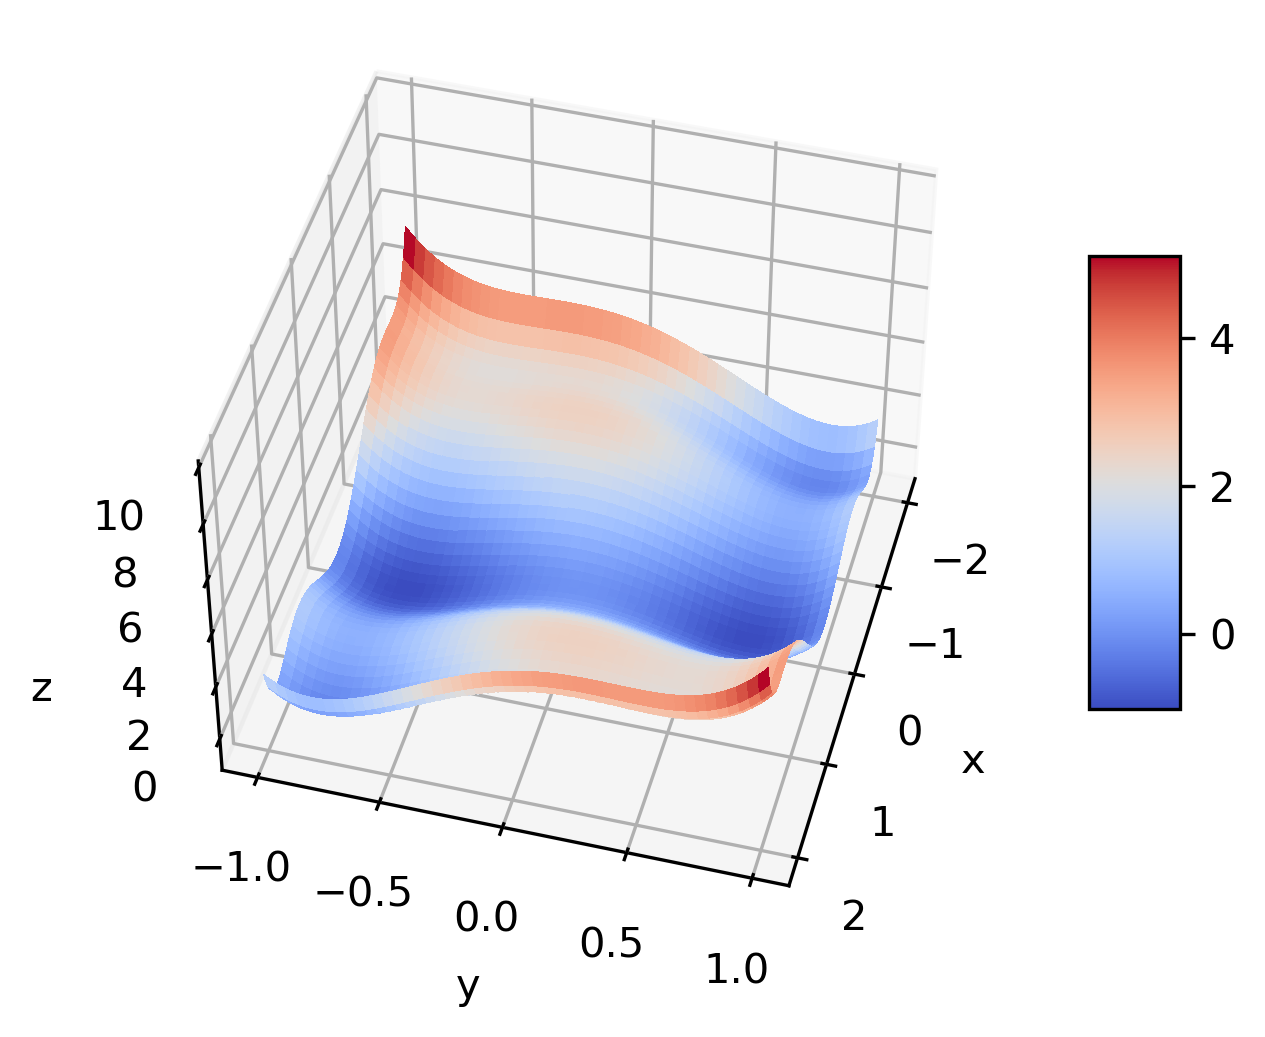

In [225]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm


r=[np.linspace(-2,2, 1000), np.linspace(-1,1, 1000)]
def f(r): return (4-2.1*r[0]**2+r[0]**4/3)*r[0]**2+r[0]*r[1]+(4*r[1]**2-4)*r[1]**2

X, Y = np.meshgrid(r[0], r[1])
Z = f([X,Y])

fig = plt.figure(dpi=300)
ax = plt.axes(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_zlim(-1, 10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(45,15)

In [226]:
from scipy.optimize import basinhopping
sol=basinhopping(f, x0=[0,0.5],stepsize=0.1, minimizer_kwargs = {"method": "BFGS"})#, minimizer_kwargs={'args': (5,)}) 
print("xmin=", sol['x'], "fmin=",f(sol['x']))

xmin= [-0.08984202  0.7126564 ] fmin= -1.0316284534898772


In [227]:
sol=basinhopping(f, x0=[0,-0.5],stepsize=0.1, minimizer_kwargs = {"method": "BFGS"})#, minimizer_kwargs={'args': (5,)}) 
print("xmin=", sol['x'], "fmin=",f(sol['x']))

xmin= [ 0.08984201 -0.7126564 ] fmin= -1.0316284534898772


In [228]:
#starting from the origin(equally distant from the global minima)
sol=basinhopping(f, x0=[0,0],stepsize=0.1, minimizer_kwargs = {"method": "BFGS"})#, minimizer_kwargs={'args': (5,)}) 
print("xmin=", sol['x'], "fmin=",f(sol['x']))
#if we run this cell multiple times we find one of the two minima due to the random nature 
#of how the function explores the space.

xmin= [-0.08984202  0.7126564 ] fmin= -1.0316284534898774


2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

Text(0.5, 0, 'Month')

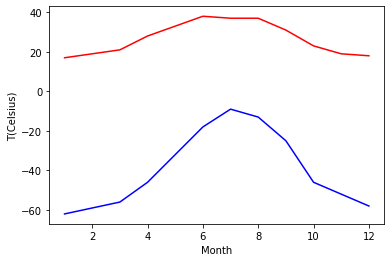

In [229]:
max=np.array([17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18])
min=np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
month=np.arange(1, 13, 1)
plt.plot(month, max, color='red')
plt.plot(month, min, color='blue')
plt.ylabel("T(Celsius)")
plt.xlabel("Month")

Physically a sign function would be the model that makes the most sense.

parameters:
 [13.67949749 21.91602832  0.27872227]
covariance matrix:
 [[ 4.18620649e+00 -4.90740067e+00  1.03641324e-02]
 [-4.90740067e+00  7.38924418e+00 -9.65139995e-03]
 [ 1.03641324e-02 -9.65139995e-03  8.88568419e-05]]


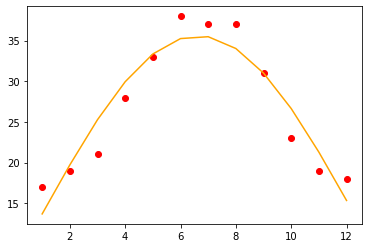

In [230]:
import scipy.optimize as optimize
def f(x, a, b,c ):
     return a+b*np.sin(c*(x-1))
popt, pcov = optimize.curve_fit(f, xdata=month, ydata=max, p0=[25,20,1/12])
print("parameters:\n", popt)
print("covariance matrix:\n", pcov)
plt.plot(month,f(month,*popt), color="orange")
plt.scatter(month,max,c="r")

parameters:
 [-72.98084699 -53.02576849  -0.26418386]
covariance matrix:
 [[ 3.81587697e+01  4.54901199e+01 -2.90666427e-02]
 [ 4.54901199e+01  6.84138114e+01 -2.35423426e-02]
 [-2.90666427e-02 -2.35423426e-02  1.33986341e-04]]


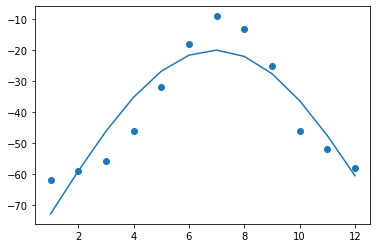

In [231]:
def f(x, a, b,c ):
     return a+b*np.sin(c*(x-1))
popt, pcov = optimize.curve_fit(f, xdata=month, ydata=min, p0=[25,20,1/12])
print("parameters:\n", popt)
print("covariance matrix:\n", pcov)
plt.plot(month,f(month,*popt))
plt.scatter(month,min)

The results of the fit aren't satisfying at all; even if not physical a gaussian seems to be a better model for this data.

parameters:
 [132.80951067   6.73581644   2.29443639  15.77931557]
covariance matrix:
 [[ 2.03783614e+02 -2.15075921e-02  2.17781905e+00 -1.61239366e+01]
 [-2.15075921e-02  6.31511232e-03 -2.12200121e-04  1.91617655e-03]
 [ 2.17781905e+00 -2.12200121e-04  2.75425314e-02 -1.70922566e-01]
 [-1.61239366e+01  1.91617655e-03 -1.70922566e-01  1.38423175e+00]]


Text(0.5, 0, 'Month')

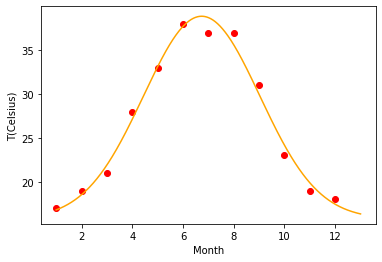

In [232]:
from scipy.stats import norm
def gauss(x, a, mu, s, c):
     return a*norm.pdf(x, mu, s) + c
popt, pcov = optimize.curve_fit(gauss, xdata=month, ydata=max)
print("parameters:\n", popt)
print("covariance matrix:\n", pcov)
plt.plot(np.linspace(1,13,1000),gauss(np.linspace(1,13,1000),*popt), color="orange")
plt.scatter(month,max, c="r")
plt.ylabel("T(Celsius)")
plt.xlabel("Month")

parameters:
 [260.76392854   7.16452594   1.97590035 -61.32093899]
covariance matrix:
 [[ 1.78561150e+02 -1.08266958e-02  8.74436572e-01 -1.45310946e+01]
 [-1.08266958e-02  2.22850079e-03 -4.92555208e-05  1.09101931e-03]
 [ 8.74436572e-01 -4.92555208e-05  5.77328693e-03 -7.06522282e-02]
 [-1.45310946e+01  1.09101931e-03 -7.06522282e-02  1.41331191e+00]]


Text(0.5, 0, 'Month')

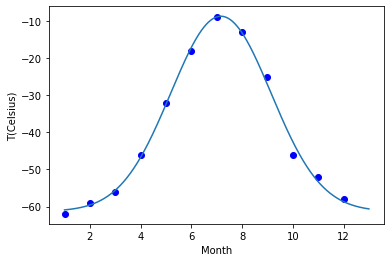

In [233]:
def gauss(x, a, mu, s, c):
     return a*norm.pdf(x, mu, s) + c
popt, pcov = optimize.curve_fit(gauss, xdata=month, ydata=min, p0=[30,6,5,-30])
print("parameters:\n", popt)
print("covariance matrix:\n", pcov)
plt.plot(np.linspace(1,13,1000),gauss(np.linspace(1,13,1000),*popt) )
plt.scatter(month, min, c="b")
plt.ylabel("T(Celsius)")
plt.xlabel("Month")

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

In [234]:
!wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P /Users/alessiogiorlandino/data


--2021-12-31 14:03:28--  https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/3uqleyc3wyz52tr/residuals_261.pkl [following]
--2021-12-31 14:03:28--  https://www.dropbox.com/s/raw/3uqleyc3wyz52tr/residuals_261.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc60cd80e88a3f70d24cfd4dfff7.dl.dropboxusercontent.com/cd/0/inline/Bc4cXnG5xbEWip0BBVsWye6_pFkmYOGZBJ4iu2CUc13_mXvTJGAGeDSLwxyxcxIPW6tb7pviD_Tg2S3i1UIarsRwA8on5-zPlN29-FtrYwcyROO1Jwt-Jin6fQvu5LgSA6KgTHO9VIqxf137zwq7fl4y/file# [following]
--2021-12-31 14:03:29--  https://uc60cd80e88a3f70d24cfd4dfff7.dl.dropboxusercontent.com/cd/0/inline/Bc4cXnG5xbEWip0BBVsWye6_pFkmYOGZBJ4iu2CUc13_mXvTJGAGeDSLwxyxcxIPW6tb7pviD_Tg2S3i1UIarsRwA8on5-zPlN29-

In [235]:
import pandas as pd
import numpy as np
data=np.load('data/residuals_261.pkl', allow_pickle=True)
res=data.item()['residuals']

Text(0.5, 0, 'x')

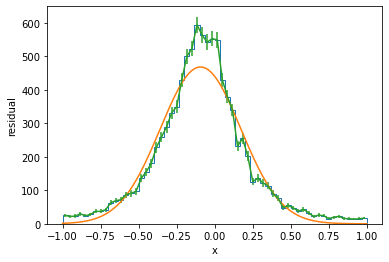

In [236]:
hist=plt.hist(res, range=(-1,1), bins=60,histtype='step')
sigma=np.sqrt(hist[0])
x=[(hist[1][i]+hist[1][i+1])/2 for i in range(len(hist[1])-1)]
def gauss(x, a, mu, s):
     return a*norm.pdf(x, mu, s)
popt, pcov = optimize.curve_fit(gauss, xdata=x, ydata=hist[0], sigma=sigma)
plt.plot(np.linspace(-1,1,1000),gauss(np.linspace(-1,1,1000),*popt) )
plt.errorbar(x,hist[0],sigma)
plt.ylabel("residual")
plt.xlabel("x")

In [237]:
yfit=gauss(x,*popt)
chi2 = np.sum(((hist[0] - yfit)**2) / sigma)
import scipy.stats as stats
pvalue = 1. - stats.chi2.cdf(chi2, df=len(x)-1)
pvalue

0.0

the gaussian model is to be excluded.

Text(0.5, 0, 'x')

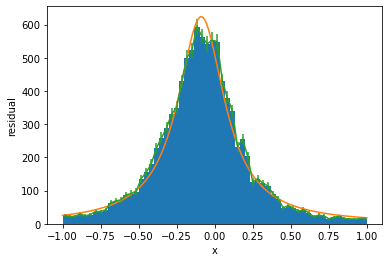

In [238]:
hist=plt.hist(res, range=(-1,1), bins=60,histtype='stepfilled')
sigma=np.sqrt(hist[0])
x=[(hist[1][i]+hist[1][i+1])/2 for i in range(len(hist[1])-1)]
from scipy.stats import cauchy
def f(x, loc, scale, a):
     return a*cauchy.pdf(x, loc, scale)
popt, pcov = optimize.curve_fit(f, xdata=x, ydata=hist[0], sigma=sigma)
plt.plot(np.linspace(-1,1,1000),f(np.linspace(-1,1,1000),*popt) )
plt.errorbar(x,hist[0],sigma)
plt.ylabel("residual")
plt.xlabel("x")

In [239]:
yfit=f(x,*popt)
chi2 = np.sum(((hist[0] - yfit)**2) / sigma)
pvalue = 1. - stats.chi2.cdf(chi2, df=len(x)-1)
pvalue

0.0

The Cauchy model at first sight seems reasonable; the fact that the pvalue is <<0.05 is probably to be attributed to the fact that the uncertainties are under estimated.

4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is necessary.

In [240]:
!wget https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt -P /Users/alessiogiorlandino/data


--2021-12-31 14:03:30--  https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt [following]
--2021-12-31 14:03:31--  https://www.dropbox.com/s/raw/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucff5e32339b745197f4a867ac0e.dl.dropboxusercontent.com/cd/0/inline/Bc5mx0dfkcP1RZuTr85FQPbHGOooyNQ7rI8GKOrfpD2FR9idjI-BazOpm4M8plo9wlR-l7wewVdPZdCic3FeXVYUfmELShRR-9m5x8e8eOsz6b8gkvZ28X8S2ghxMuc1hmu6NrJYfoyggIg6SD9LvL5R/file# [following]
--2021-12-31 14:03:31--  https://ucff5e32339b745197f4a867ac0e.dl.dropboxusercontent.com/cd/0/inline/Bc5mx0dfkcP1RZuTr

In [241]:
data = np.loadtxt("/Users/alessiogiorlandino/data/munich_temperatures_average_with_bad_data.txt")
x,y=data.T

In [242]:
period=(x>2008) * (x<2012)
x=x[period]
y=y[period]

(-15.0, 30.0)

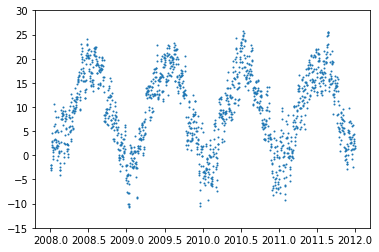

In [243]:
plt.scatter(x,y, s=1)
plt.ylim(-15,30)

RSS= 34359.85859996652


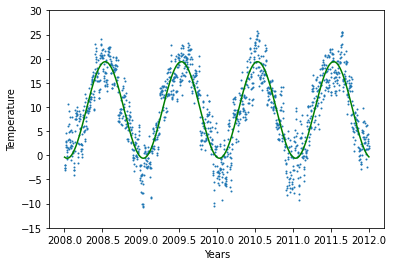

In [244]:
def model(x, a, b, c):
    return c+a*np.cos(2*np.pi*x+b)
popt, pcov = optimize.curve_fit(model, xdata=x, ydata=y)
plt.plot(x,model(x,*popt), color="green")
plt.scatter(x,y, s=1)
plt.ylim(-15,30)
plt.ylabel("Temperature")
plt.xlabel("Years")
RSS=np.sum((y-model(x,*popt))**2)
print("RSS=",RSS)

In [245]:
popt[0]=np.abs(popt[0])
print("values found: a=", popt[0], "b=", popt[1], "c=",popt[2])

values found: a= 9.988133676295126 b= 12.33302301420083 c= 9.384114874048437


The average temperature throughout the year is given by c=9.38 C


The predicted average maximum and minimum are give by c+a and c-a: 

In [246]:
print("average predcited minimum:", popt[0]-popt[2],"C")
print("average predicted maximum:", popt[0]+popt[2], "C")

average predcited minimum: 0.6040188022466886 C
average predicted maximum: 19.372248550343564 C


The b parameter represents just a time shift. So it doesn't have a strong physical meaning; it only gives the right phase to the fitted model. 

RSS= 34352.79405382182


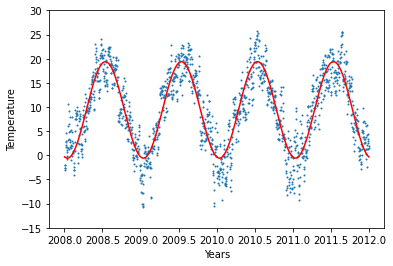

In [247]:
def g(x, a, b, c, d):
    return d + a * np.cos(2*b*np.pi*x+c)
popt2, pcov = optimize.curve_fit(g, xdata=x, ydata=y)
plt.plot(x,g(x,*popt2), color="red")
plt.scatter(x,y, s=1)
plt.ylim(-15,30)
plt.ylabel("Temperature")
plt.xlabel("Years")
RSS2=np.sum((y-g(x,*popt2))**2)
print("RSS=",RSS2)

In [248]:
popt2[0]=np.abs(popt2[0])
print("values found: a=", popt2[0], "b=", popt2[1], "c=",popt2[2], "d=", popt2[3])

values found: a= 9.982181754009193 b= 1.0014440121072616 c= -5.904151584312908 d= 9.398124478162677


Qualitatively the fact that the extra parameter takes a value that is really close to 1, means that we didn't need to introduce. Quantitatively we can study the RSSs thru the Fisher-Test:

In [249]:
def Ftest(ssr_1, ssr_2, ndof_1, ndof_2, points, verbose=False):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(points - ndof_2))
    CL = 1. - stats.f.cdf(F, ndof_2 - ndof_1, points - ndof_2)
    if verbose: print("CL: %.3f" % CL, ", additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL
Ftest(RSS, RSS2, len(popt), len(popt2), len(x), verbose=True)

CL: 0.584 , additional parameter necessary: NO


0.5841998375041437